# TestCase5 - ErrorMap

In [1]:
# sélection du cas test
testcase = 5
version = 2
degree = 1
param_num = 1

In [2]:
assert testcase == 5 and version in [1,2]

**Idée :** On se place ici dans le TestCase3.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
from dolfin import *
import seaborn as sns

# from modfenics.fenics_expressions.fenics_expressions_2D import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from testcases.utils import create_tree
from testcases.geometry.geometry_2D import Donut,Circle
from modfenics.fenics_expressions.fenics_expressions_2D import FExpr,UexExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [5]:
if version == 1:
    from testcases.networks.test_2D.test_5.test_5_v1 import Run_laplacian2D,Poisson_2D
elif version == 2 :
    from testcases.networks.test_2D.test_5.test_5_v2 import Run_laplacian2D,Poisson_2D
from modfenics.solver_fem.solver_fem_5 import FEMSolver
from testcases.problem.problem_2D import TestCase5
problem = TestCase5(v=version)

dim_params = problem.nb_parameters
result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

torch loaded; device is cuda
hmax =  0.13306504232756408


bigcenter :  [0.0, 0.0]
bigradius :  1.0
smallcenter :  [0.0, 0.0]
smallradius :  0.25
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
init
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe5_v2.pth
network loaded
Error  tensor([0.0003])


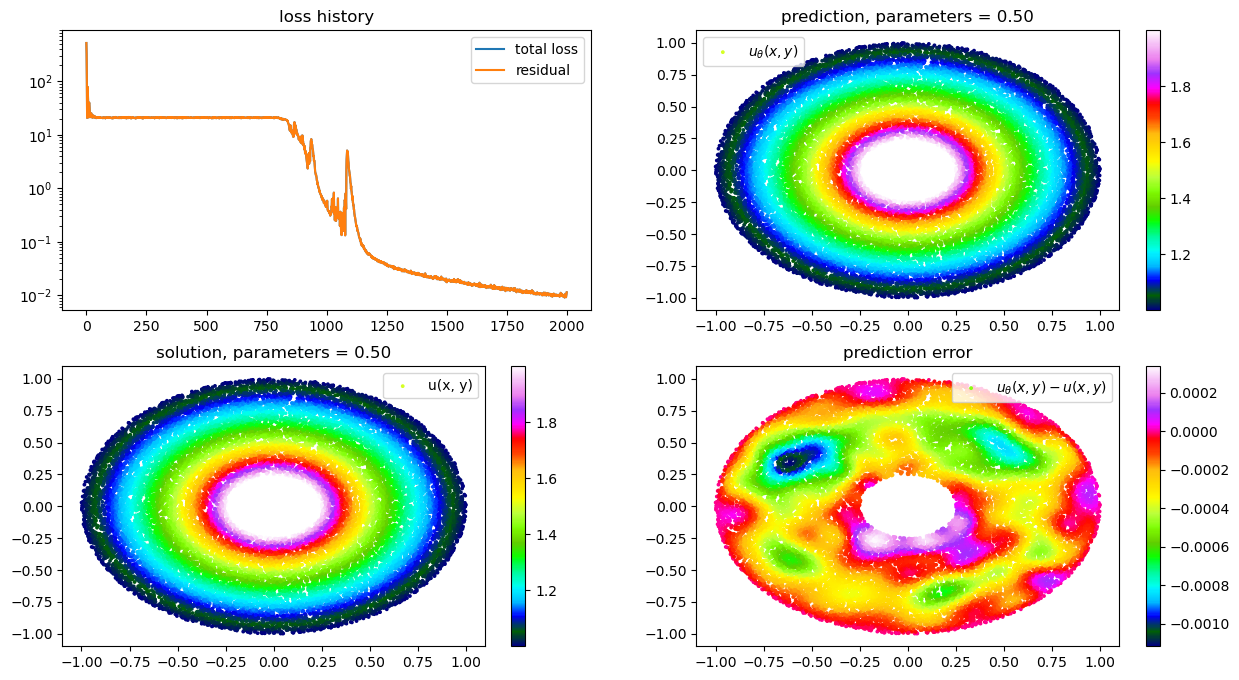

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
params = [param]
params_str = np.array([f"{param}"])
params

[array([0.5])]

## Erreurs PINNs

In [8]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [9]:
nb_vert = 16
deg = 1
solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=deg)
degree_PINNs = solver.high_degree
print("param =",end=" ")
V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)

hmax =  0.16660094771444728
param = 

In [10]:
u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()
pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_FE = df.Function(V_test)
u_theta_FE.vector()[:] = u_theta_.copy()

In [11]:
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
u_theta.get_third_derivatives(pred, X_test)

## Dérivées premières

In [12]:
du_ex_dx,du_ex_dy = pde.reference_gradient(X_test, mu_test)
du_ex_dx,du_ex_dy = du_ex_dx[:,0].cpu().detach().numpy(),du_ex_dy[:,0].cpu().detach().numpy()

du_ex_dx_FE = df.Function(V_test)
du_ex_dx_FE.vector()[:] = du_ex_dx.copy()

du_ex_dy_FE = df.Function(V_test)
du_ex_dy_FE.vector()[:] = du_ex_dy.copy()

u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_x_FE = df.Function(V_test)
u_theta_x_FE.vector()[:] = u_theta_x.copy()

u_theta_y = pred["w_y"][:,0].cpu().detach().numpy()
u_theta_y_FE = df.Function(V_test)
u_theta_y_FE.vector()[:] = u_theta_y.copy()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


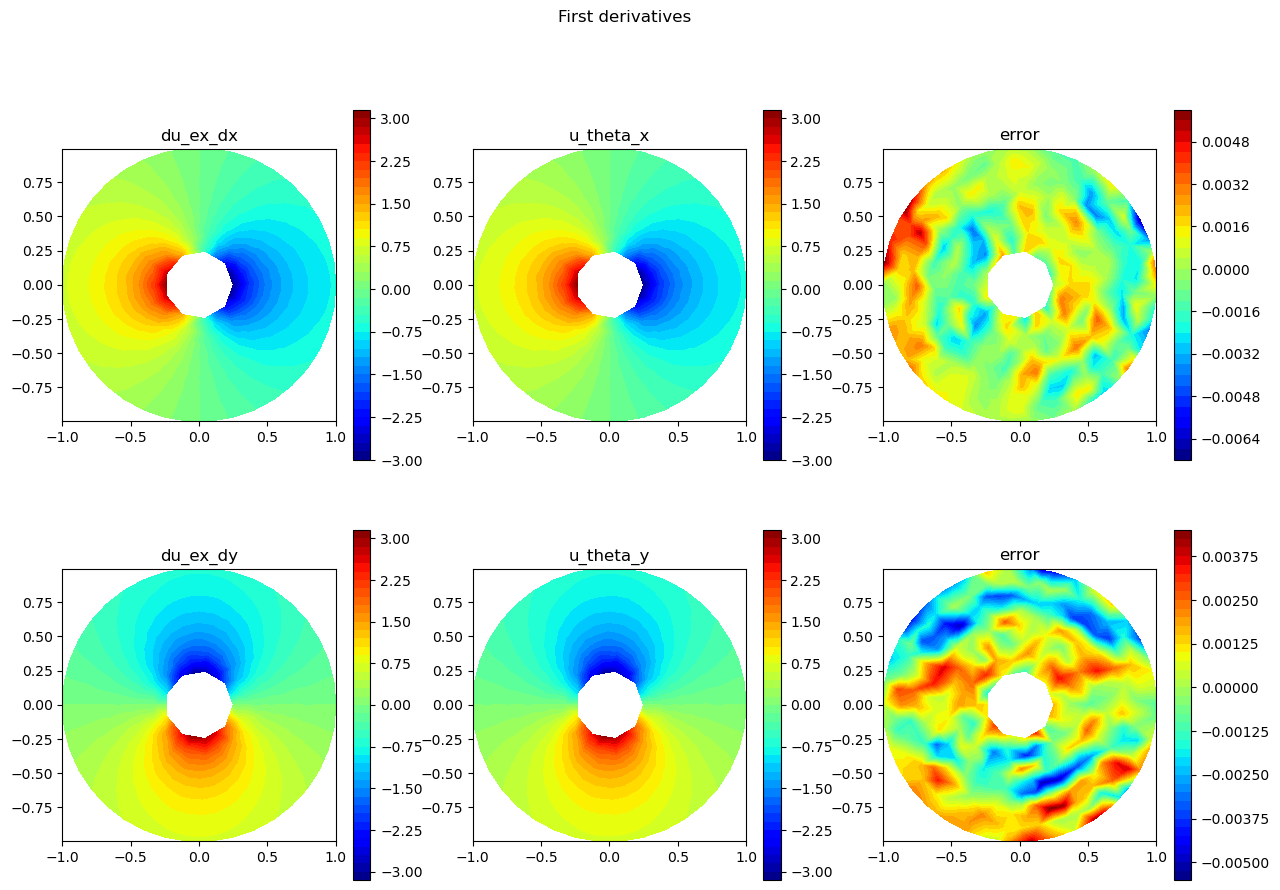

In [13]:
colormap = "jet"

plt.figure(figsize=(15,10))

# plot derivatives in x
plt.subplot(2,3,1)
c = plot(du_ex_dx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("du_ex_dx")

plt.subplot(2,3,2)
c = plot(u_theta_x_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_x")

plt.subplot(2,3,3)
c = plot(du_ex_dx_FE - u_theta_x_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.subplot(2,3,4)
c = plot(du_ex_dy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("du_ex_dy")

plt.subplot(2,3,5)
c = plot(u_theta_y_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_y")

plt.subplot(2,3,6)
c = plot(du_ex_dy_FE - u_theta_y_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.suptitle("First derivatives")
plt.savefig(result_dir+f"errormap_{0}_N{nb_vert}_P{deg}_first_derivatives.png")

## Dérivées secondes

In [14]:
d2u_ex_dxx,d2u_ex_dyy = pde.reference_gradient2(X_test, mu_test)
d2u_ex_dxx,d2u_ex_dyy = d2u_ex_dxx[:,0].cpu().detach().numpy(),d2u_ex_dyy[:,0].cpu().detach().numpy()

d2u_ex_dxx_FE = df.Function(V_test)
d2u_ex_dxx_FE.vector()[:] = d2u_ex_dxx.copy()

d2u_ex_dyy_FE = df.Function(V_test)
d2u_ex_dyy_FE.vector()[:] = d2u_ex_dyy.copy()

u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()
u_theta_xx_FE = df.Function(V_test)
u_theta_xx_FE.vector()[:] = u_theta_xx.copy()

u_theta_yy = pred["w_yy"][:,0].cpu().detach().numpy()
u_theta_yy_FE = df.Function(V_test)
u_theta_yy_FE.vector()[:] = u_theta_yy.copy()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


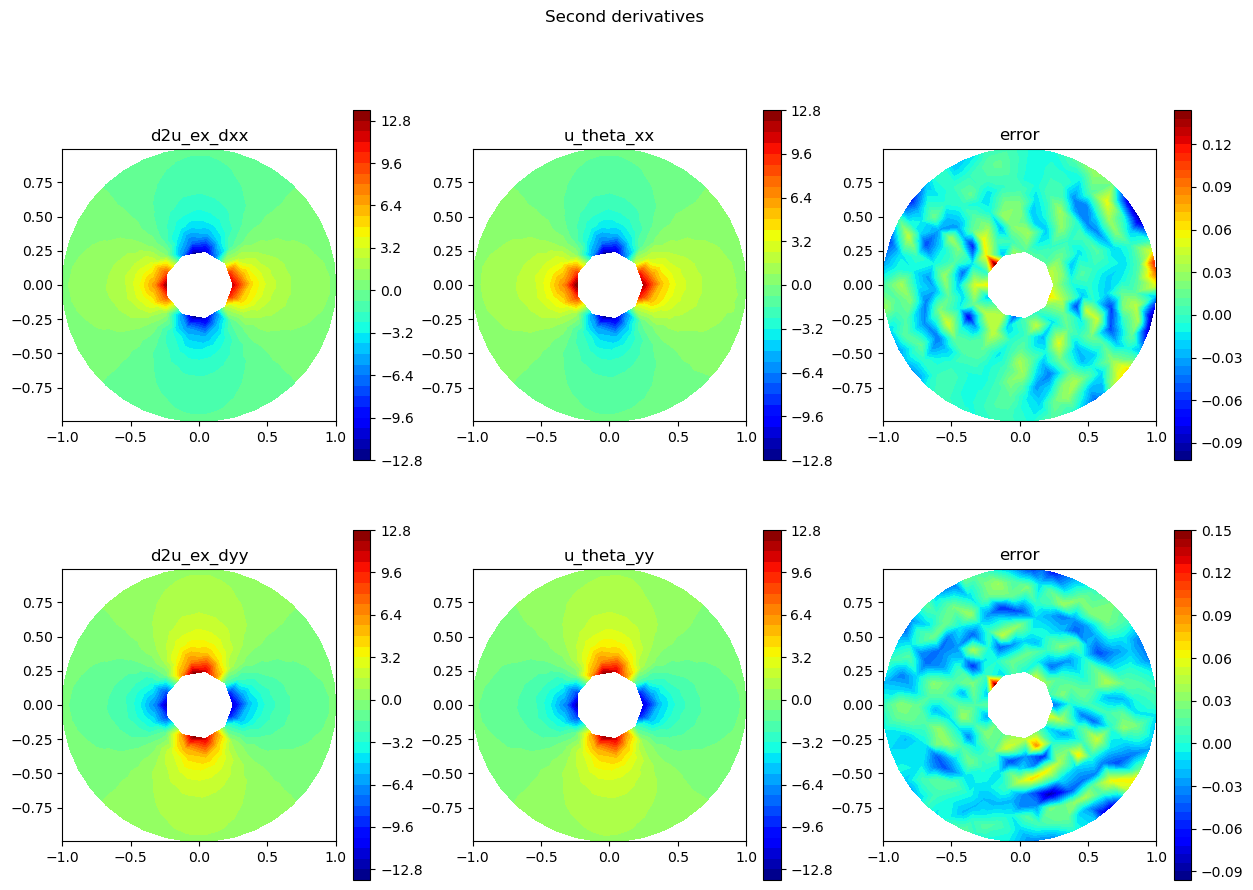

In [15]:
colormap = "jet"

plt.figure(figsize=(15,10))

# plot derivatives in x
plt.subplot(2,3,1)
c = plot(d2u_ex_dxx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("d2u_ex_dxx")

plt.subplot(2,3,2)
c = plot(u_theta_xx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_xx")

plt.subplot(2,3,3)
c = plot(d2u_ex_dxx_FE - u_theta_xx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.subplot(2,3,4)
c = plot(d2u_ex_dyy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("d2u_ex_dyy")

plt.subplot(2,3,5)
c = plot(u_theta_yy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_yy")

plt.subplot(2,3,6)
c = plot(d2u_ex_dyy_FE - u_theta_yy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.suptitle("Second derivatives")
plt.savefig(result_dir+f"errormap_{0}_N{nb_vert}_P{deg}_second_derivatives.png")

## Dérivées troisièmes

In [16]:
d3u_ex_dxxx,d3u_ex_dyyy = pde.reference_gradient3(X_test, mu_test)
d3u_ex_dxxx,d3u_ex_dyyy = d3u_ex_dxxx[:,0].cpu().detach().numpy(),d3u_ex_dyyy[:,0].cpu().detach().numpy()

d3u_ex_dxxx_FE = df.Function(V_test)
d3u_ex_dxxx_FE.vector()[:] = d3u_ex_dxxx.copy()

d3u_ex_dyyy_FE = df.Function(V_test)
d3u_ex_dyyy_FE.vector()[:] = d3u_ex_dyyy.copy()

u_theta_xxx = pred["w_xxx"][:,0].cpu().detach().numpy()
u_theta_xxx_FE = df.Function(V_test)
u_theta_xxx_FE.vector()[:] = u_theta_xxx.copy()

u_theta_yyy = pred["w_yyy"][:,0].cpu().detach().numpy()
u_theta_yyy_FE = df.Function(V_test)
u_theta_yyy_FE.vector()[:] = u_theta_yyy.copy()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


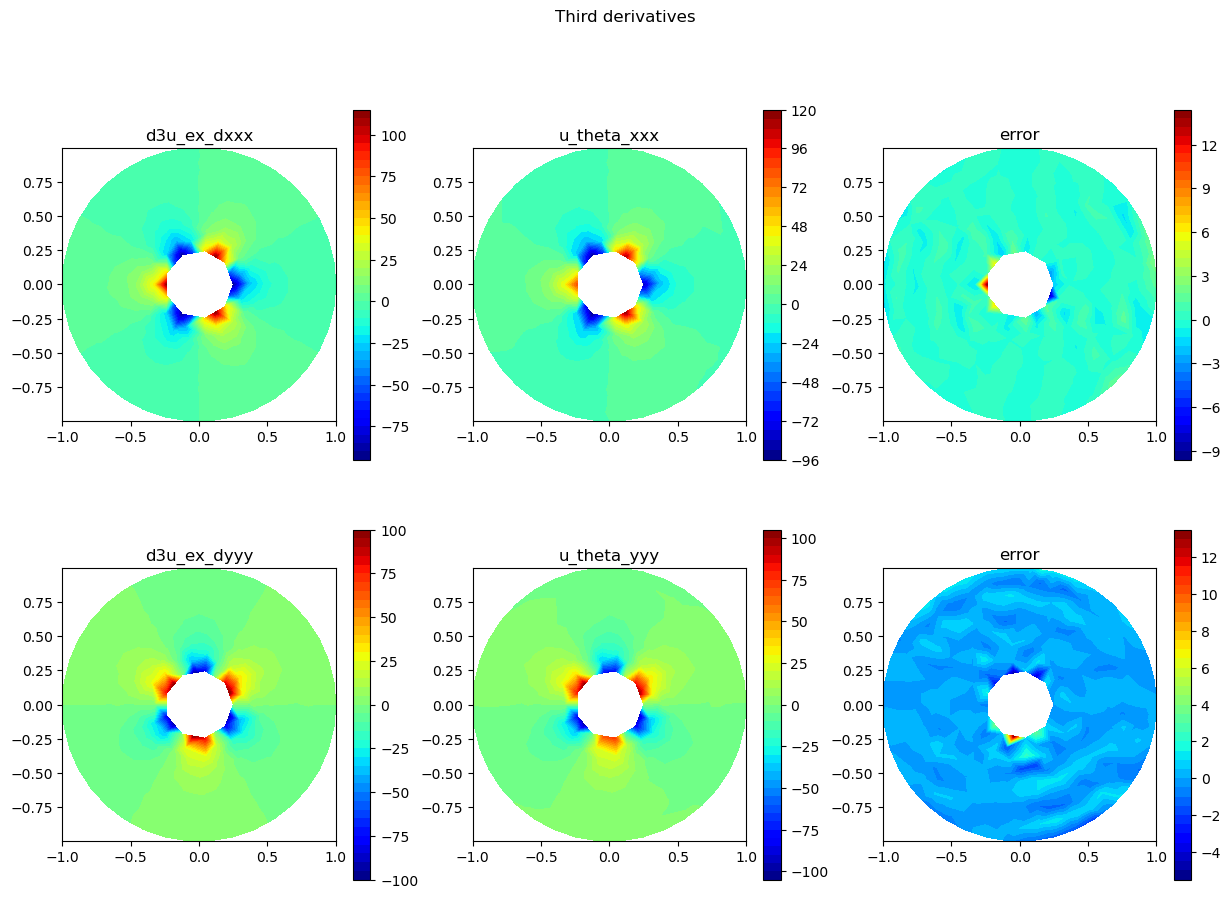

In [17]:
colormap = "jet"

plt.figure(figsize=(15,10))

# plot derivatives in x
plt.subplot(2,3,1)
c = plot(d3u_ex_dxxx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("d3u_ex_dxxx")

plt.subplot(2,3,2)
c = plot(u_theta_xxx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_xxx")

plt.subplot(2,3,3)
c = plot(d3u_ex_dxxx_FE - u_theta_xxx_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.subplot(2,3,4)
c = plot(d3u_ex_dyyy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("d3u_ex_dyyy")

plt.subplot(2,3,5)
c = plot(u_theta_yyy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("u_theta_yyy")

plt.subplot(2,3,6)
c = plot(d3u_ex_dyyy_FE - u_theta_yyy_FE,cmap=colormap)
plt.colorbar(c)
plt.title("error")

plt.suptitle("Third derivatives")
plt.savefig(result_dir+f"errormap_{0}_N{nb_vert}_P{deg}_third_derivatives.png")